In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore") # suppress the annpoying yfinance deprecation warnings

# Adding the root folder to sys path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from dataclasses import fields
from rich.console import Console
from rich.table import Table
from rich.pretty import pprint
from src.data.loaders import YFinanceLoader
from src.data.loaders import FamaFrenchLoader
from src.data.processing import DataProcessor
from src.data.metrics import FinancialMetrics
from src.index import IndexBuilder
from src.portfolio import PortfolioOptimizer
from src.config import AssignmentConfig
from src.plotting import PlottingUtil
from src.model import AssetPricingModel

In [3]:
console = Console()
default_config = AssignmentConfig()

#### Loading default configuration defined for this assignment from the dataclass

In [4]:
table = Table(title="Default Configuration")
table.add_column("Field", style="bright_blue", no_wrap=True)
table.add_column("Value", style="bright_green")

# Iterate over the fields of the dataclass and add them to the table
for f in fields(default_config):
    table.add_row(f.name, str(getattr(default_config, f.name)))

console.print(table)

                           Default Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field                         ┃ Value                                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ trading_days                  │ 252                                      │
│ stock_list                    │ ['AAPL', 'MSFT', 'GOOGL', 'XOM', 'INTC'] │
│ benchmark_index               │ ^GSPC                                    │
│ risk_free_rate                │ 0.04                                     │
│ daily_adjusted_risk_free_rate │ 0.0001556498627912628                    │
│ start_date                    │ 2015-01-01                               │
│ end_date                      │ 2024-12-31                               │
└───────────────────────────────┴──────────────────────────────────────────┘

In [5]:
loader = YFinanceLoader()
df_olhcv = loader.get_daily_ohlcv(default_config.stock_list + [default_config.benchmark_index], "2015-01-01", "2024-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df_olhcv.Symbol.unique()

array(['AAPL', 'MSFT', 'GOOGL', 'XOM', 'INTC', '^GSPC'], dtype=object)

#### Just to show that they all have market cap >= 10 billion

In [7]:
loader.get_stock_info(default_config.stock_list ,["marketCap"])

,marketCap,symbol
0,3775840124928,AAPL
1,3785191325696,MSFT
2,3047268548608,GOOGL
3,485797003264,XOM
4,137025478656,INTC


Normalize by the first value of the sequence (normalize_method = "rebasing")

In [8]:
data_processor = DataProcessor(input_olhcv_data=df_olhcv, normalize_method="rebasing")
df_olhcv_processed = data_processor.process_data()

#### After normalization, when we groupby each symbol, the first value of `return` will always be `NaN` and the first `Close_normalized` will always be 1

In [9]:
df_olhcv_processed.groupby("Symbol").head(2)

,Date,Close,High,Low,Open,Volume,Symbol,Return,Close_normalized
0,2015-01-02,24.261049,24.729272,23.821673,24.718176,212818400,AAPL,NaN,1.000000
1,2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000,AAPL,-0.028172,0.971828
2515,2015-01-02,26.296135,26.606494,26.213205,26.447589,26480000,GOOGL,NaN,1.000000
2516,2015-01-05,25.795088,26.218667,25.710175,26.176955,41182000,GOOGL,-0.019054,0.980946
5030,2015-01-02,27.896458,28.510241,27.704650,28.134297,23605600,INTC,NaN,1.000000
5031,2015-01-05,27.581898,27.965512,27.574224,27.773705,32785000,INTC,-0.011276,0.988724
7545,2015-01-02,39.933056,40.496696,39.745178,39.847657,27913900,MSFT,NaN,1.000000
7546,2015-01-05,39.565838,39.907436,39.497516,39.599995,39673900,MSFT,-0.009196,0.990804
10060,2015-01-02,58.423485,58.561945,57.781535,58.058455,10220400,XOM,NaN,1.000000
10061,2015-01-05,56.824894,58.152843,56.327699,57.964034,18502400,XOM,-0.027362,0.972638


#### Plotting normalized closing price

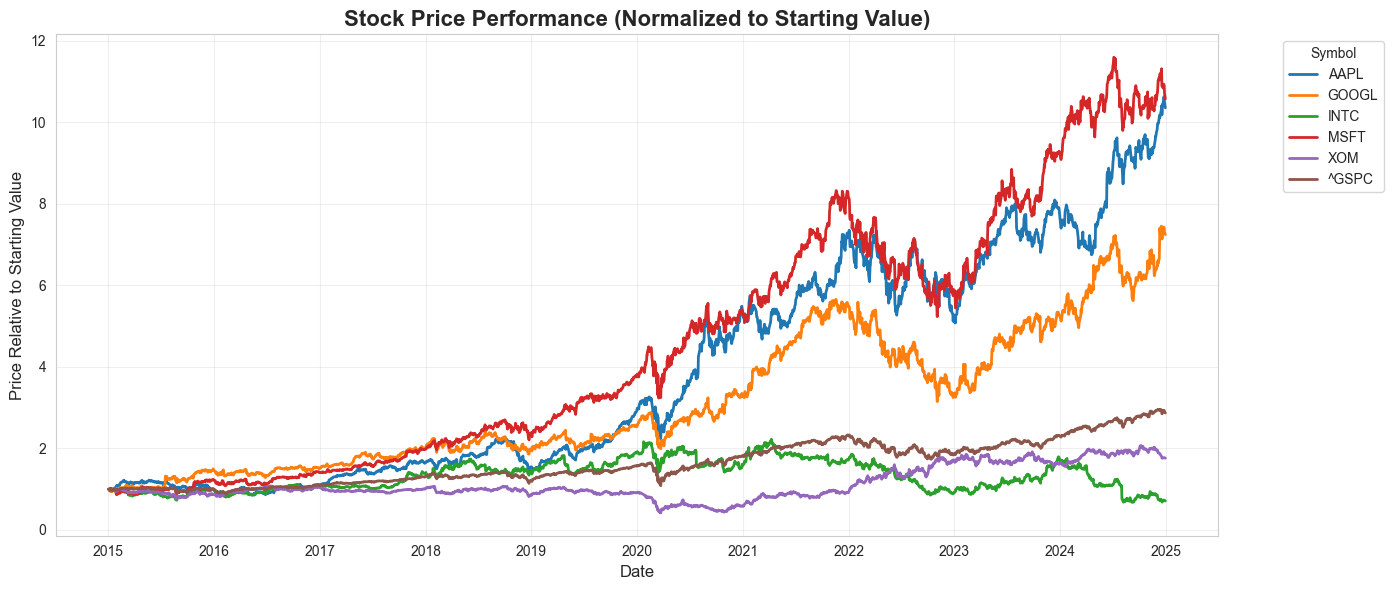

In [10]:
PlottingUtil.plot_stock_performance(df_olhcv_processed)

Annualized Return & Volatility

In [11]:
table = Table(title="Financial Metrics per Symbol")

table.add_column("Symbol", justify="right", style="blue", no_wrap=True)
table.add_column("Annualized Return (Arithmetic)", justify="right", style="purple")
table.add_column("Annualized Return (Geometric)", justify="right", style="bright_green")
table.add_column("Annualized Volatility", justify="right", style="bright_yellow")

for symbol in df_olhcv_processed['Symbol'].unique():
    df_symbol = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == symbol, "Close_normalized"].pct_change().dropna()
    
    financial_metrics = FinancialMetrics(df_symbol)
    annualized_return_arith = financial_metrics.annualized_return(method="arithmetic")
    annualized_return_geom = financial_metrics.annualized_return(method="geometric")
    annualized_volatility = financial_metrics.annualized_volatility()
    
    # Add a row to the table for each symbol
    table.add_row(
        symbol,
        f"{annualized_return_arith:.2%}",
        f"{annualized_return_geom:.2%}",
        f"{annualized_volatility:.2%}"
    )

console.print(table)

                                   Financial Metrics per Symbol                                    
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Symbol ┃ Annualized Return (Arithmetic) ┃ Annualized Return (Geometric) ┃ Annualized Volatility ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│   AAPL │                         27.50% │                        26.41% │                28.46% │
│  GOOGL │                         23.91% │                        21.96% │                28.47% │
│   INTC │                          3.04% │                        -3.37% │                35.66% │
│   MSFT │                         27.34% │                        26.68% │                27.14% │
│    XOM │                          9.53% │                         5.84% │                27.78% │
│  ^GSPC │                         12.17% │                        11.15% │                17.83% │
└────────┴────────────────────────────────┴───────────────────────────────┴───────────────────────┘

In [12]:
df_exclude_sp = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] != '^GSPC'].reset_index(drop=True)

index_builder = IndexBuilder(input_data=df_exclude_sp)
df_equal_weighted_index = index_builder.build_equal_weighted_index(base_value=1.0) # base value is an optional parameter
df_price_weighted_index = index_builder.build_price_weighted_index()

In [13]:
df_equal_weighted_index.head()

,Date,Equal_Weighted_Index
0,2015-01-02,NaN
1,2015-01-05,0.980988
2,2015-01-06,0.968585
3,2015-01-07,0.979219
4,2015-01-08,1.000090


In [14]:
df_price_weighted_index.head()

,Date,Price_Weighted_Index
0,2015-01-02,1.000000
1,2015-01-05,0.980988
2,2015-01-06,0.968537
3,2015-01-07,0.979211
4,2015-01-08,1.000205


In [15]:
index_df_combined = (
    df_equal_weighted_index.merge(
        df_price_weighted_index, on="Date", how="inner"
    )
    .merge(
        df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == '^GSPC', ['Date', 'Close_normalized']],
        on="Date",
        how="inner"
    )
    .rename(columns={"Close_normalized": "SP_500"})
    .dropna()
    .reset_index(drop=True)
)

In [16]:
index_df_combined.head()

,Date,Equal_Weighted_Index,Price_Weighted_Index,SP_500
0,2015-01-05,0.980988,0.980988,0.981722
1,2015-01-06,0.968585,0.968537,0.972991
2,2015-01-07,0.979219,0.979211,0.984307
3,2015-01-08,1.000090,1.000205,1.001914
4,2015-01-09,0.996281,0.996481,0.993494


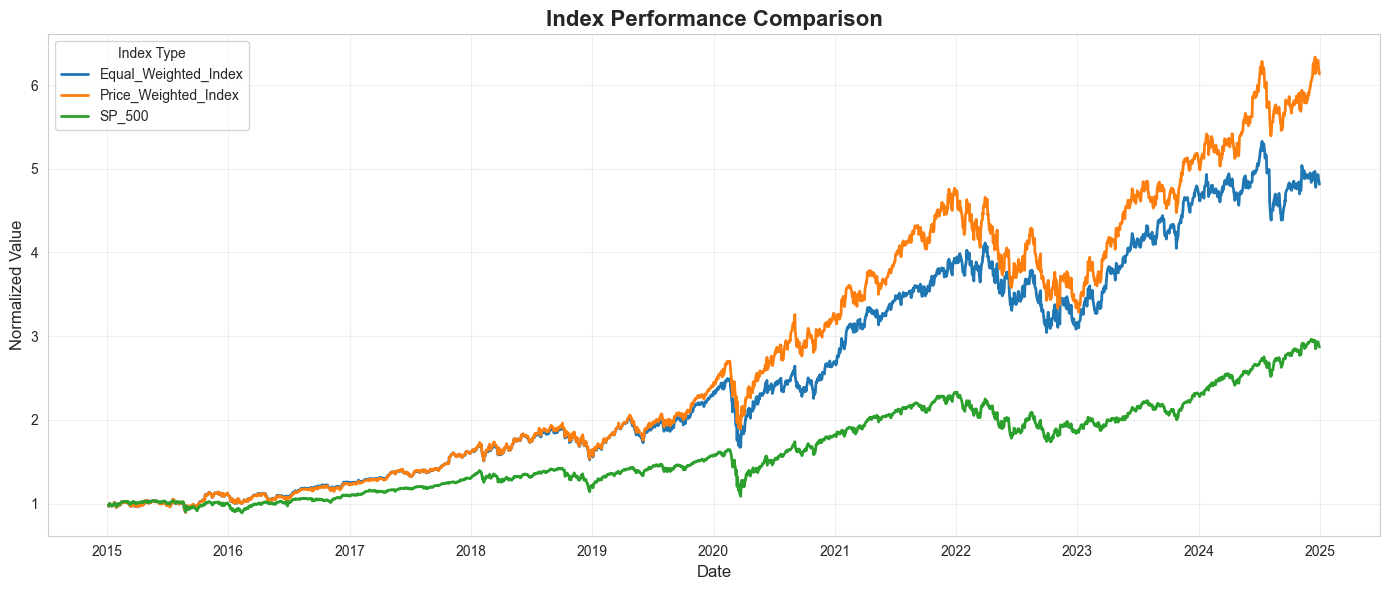

In [17]:
PlottingUtil.plot_index_performance(index_df_combined)

In [18]:

table = Table(title="Annualized Financial Metrics for the Indexes")

table.add_column("Index", justify="right", style="blue", no_wrap=True)
table.add_column("Annualized Return (Arithmetic)", justify="right", style="purple")
table.add_column("Annualized Return (Geometric)", justify="right", style="bright_green")
table.add_column("Annualized Volatility", justify="right", style="bright_yellow")


for col in [i for i in index_df_combined.columns if i != "Date"]:
    series = index_df_combined[col].pct_change().dropna()
    financial_metrics = FinancialMetrics(series)
    
    annualized_return_arith = financial_metrics.annualized_return(method="arithmetic")
    annualized_return_geom = financial_metrics.annualized_return(method="geometric")
    annualized_volatility = financial_metrics.annualized_volatility()
    
    table.add_row(
        col,
        f"{annualized_return_arith:.2%}",
        f"{annualized_return_geom:.2%}",
        f"{annualized_volatility:.2%}"
    )

console.print(table)


                                  Annualized Financial Metrics for the Indexes                                   
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Index ┃ Annualized Return (Arithmetic) ┃ Annualized Return (Geometric) ┃ Annualized Volatility ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Equal_Weighted_Index │                         18.46% │                        17.30% │                22.33% │
│ Price_Weighted_Index │                         21.08% │                        20.18% │                23.19% │
│               SP_500 │                         12.35% │                        11.36% │                17.82% │
└──────────────────────┴────────────────────────────────┴───────────────────────────────┴───────────────────────┘

#### Market Portfolio A:
Portfolio constructed using the 3 stocks that come from the same sector and have positive returns for the past 10 years

In [19]:
df_portfolio_a = df_olhcv_processed.loc[df_olhcv_processed['Symbol'].isin(['AAPL', 'GOOGL', 'MSFT'])]

In [20]:
portfolio_optimizer = PortfolioOptimizer(input_data=df_portfolio_a, 
                                         risk_free_rate=default_config.risk_free_rate, 
                                         iterations=10000)
# We are using the arithmetic annualized return for the calculation here for simplicity

results, max_sharpe_portfolio, min_volatility_portfolio = portfolio_optimizer.monte_carlo_optimization()

In [21]:
results.head()

,Return,Volatility,Sharpe Ratio,Weight_AAPL,Weight_GOOGL,Weight_MSFT
0,0.257807,0.249964,0.871355,0.182059,0.462129,0.355812
1,0.268537,0.256248,0.891858,0.657381,0.171323,0.171296
2,0.253952,0.256982,0.832558,0.038078,0.567845,0.394077
3,0.273622,0.253944,0.919973,0.416865,0.012119,0.571017
4,0.268509,0.257438,0.887627,0.678655,0.173111,0.148234


In [22]:
pprint(max_sharpe_portfolio)

Return          0.271562
Volatility      0.251418
Sharpe Ratio    0.921023
Weight_AAPL     0.412504
Weight_GOOGL    0.071934
Weight_MSFT     0.515562
Name: 6089, dtype: float64

In [23]:
pprint(min_volatility_portfolio)

Return          0.263300
Volatility      0.246924
Sharpe Ratio    0.904327
Weight_AAPL     0.332790
Weight_GOOGL    0.308997
Weight_MSFT     0.358212
Name: 9852, dtype: float64

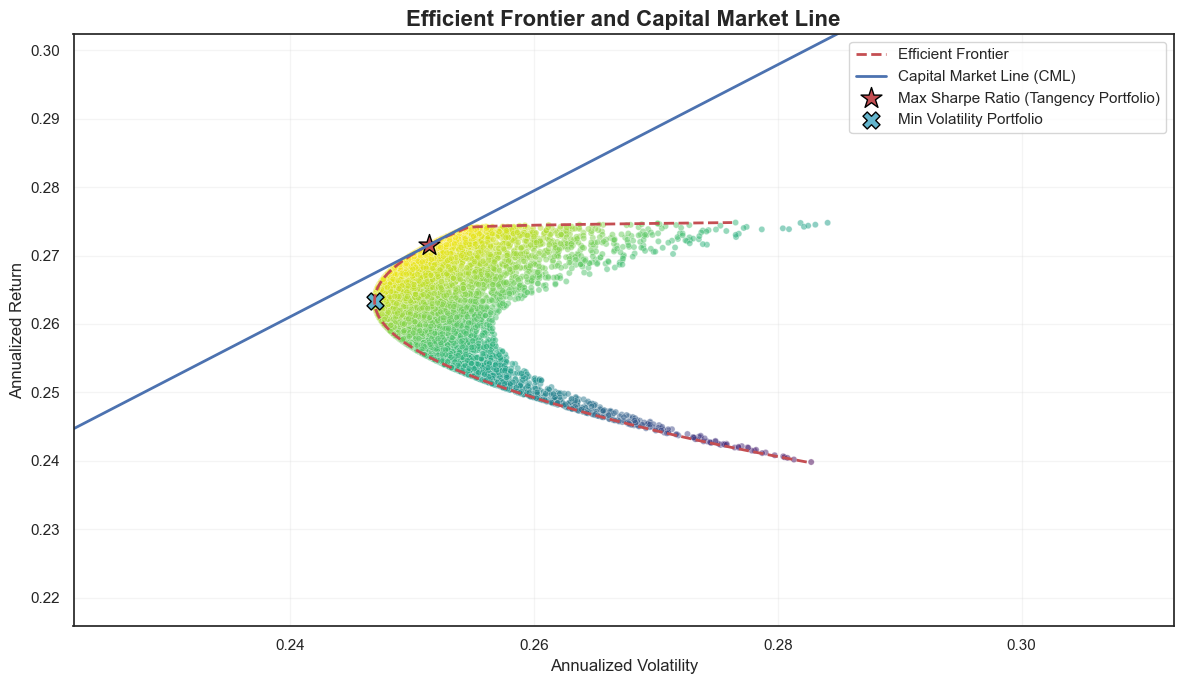

In [24]:
efficient_frontier = portfolio_optimizer.calculate_efficient_frontier(results, 1000)

cml_x, cml_y = portfolio_optimizer.calculate_cml(max_sharpe_portfolio, results)

PlottingUtil.plot_portfolio_optimization_results(results, 
                                                 efficient_frontier, 
                                                 cml_x, 
                                                 cml_y, 
                                                 max_sharpe_portfolio, 
                                                 min_volatility_portfolio)

In [25]:
optimal_weights = max_sharpe_portfolio.filter(like="Weight_")

portfolio_return = pd.Series(
    np.dot(portfolio_optimizer.returns, optimal_weights), 
)

market_return = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == '^GSPC',"Return"].dropna().reset_index(drop=True)

In [26]:
df_returns = pd.DataFrame({
    "Portfolio_Return": portfolio_return,
    "Market_Return": market_return
})

df_returns['Portfolio_Excess_Return'] = df_returns['Portfolio_Return'] - default_config.daily_adjusted_risk_free_rate
df_returns['Market_Excess_Return'] = df_returns['Market_Return'] - default_config.daily_adjusted_risk_free_rate

In [27]:
# Return skips the first trading day which is 2015-01-02
# so we set the start date to 2015-01-05 to ensure we have data

# 12-31 is also not a trading day
ff_loader = FamaFrenchLoader(start="2015-01-05", end="2024-12-30")
df_ff_factors = ff_loader.get_ff_momentum_factor()

In [28]:
pricing_model = AssetPricingModel(df_returns, default_config.daily_adjusted_risk_free_rate)

In [29]:
pprint(pricing_model.fit_capm_model())

{
│   'beta': 1.200873679627039,
│   'alpha': 0.0005291083701618969,
│   'annualized_alpha': 0.13333530928079804,
│   'r_squared': np.float64(0.7253237787154141),
│   'p_value_alpha': np.float64(0.0014200133008270392),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0001656515066628218),
│   'std_err_beta': np.float64(0.014744569029783704)
}

In [30]:
pprint(pricing_model.fit_fama_french_3f_model(df_ff_factors))

{
│   'betas': Mkt-RF    0.011846
SMB      -0.003697
HML      -0.004338
dtype: float64,
│   'alpha': np.float64(0.0002836946745819398),
│   'annualized_alpha': np.float64(0.07149105799464883),
│   'r_squared': np.float64(0.7961720077747287),
│   'p_value_alpha': np.float64(0.04714373233786385),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00014284842968177809),
│   'std_err_beta': np.float64(0.00012720542093303227)
}

In [31]:
pprint(pricing_model.fit_carhart_4f_model(df_ff_factors))

{
│   'betas': Mkt-RF    0.011916
SMB      -0.003508
HML      -0.004106
MOM       0.000580
dtype: float64,
│   'alpha': np.float64(0.0002771454791728819),
│   'annualized_alpha': np.float64(0.06984066075156624),
│   'r_squared': np.float64(0.7975444823497283),
│   'p_value_alpha': np.float64(0.051743063324468604),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00014240390566102394),
│   'std_err_beta': np.float64(0.00012792551826051673)
}

#### Market Portfolio B:
Using all 5 stocks

In [32]:
df_all_stocks = df_olhcv_processed.loc[df_olhcv_processed['Symbol'].isin(default_config.stock_list)]

In [33]:
portfolio_optimizer = PortfolioOptimizer(input_data=df_all_stocks, risk_free_rate=default_config.risk_free_rate, iterations=10000)

results, max_sharpe_portfolio, min_volatility_portfolio = portfolio_optimizer.monte_carlo_optimization()

In [34]:
results.head()

,Return,Volatility,Sharpe Ratio,Weight_AAPL,Weight_GOOGL,Weight_INTC,Weight_MSFT,Weight_XOM
0,0.188853,0.241233,0.617050,0.133197,0.338101,0.260318,0.212900,0.055485
1,0.131806,0.234542,0.391428,0.065285,0.024308,0.362501,0.251571,0.296334
2,0.152545,0.250892,0.448580,0.009284,0.437468,0.375464,0.095773,0.082010
3,0.164187,0.232885,0.533256,0.105673,0.175297,0.302353,0.248877,0.167800
4,0.189771,0.221407,0.676454,0.327909,0.074759,0.156568,0.196343,0.244421


In [35]:
optimal_weights = max_sharpe_portfolio.filter(like="Weight_")
portfolio_return = pd.Series(
    np.dot(portfolio_optimizer.returns, optimal_weights), 
)

df_returns = pd.DataFrame({
    "Portfolio_Return": portfolio_return,
    "Market_Return": market_return
})

df_returns['Portfolio_Excess_Return'] = df_returns['Portfolio_Return'] - default_config.daily_adjusted_risk_free_rate
df_returns['Market_Excess_Return'] = df_returns['Market_Return'] - default_config.daily_adjusted_risk_free_rate

In [36]:
pricing_model = AssetPricingModel(df_returns, default_config.daily_adjusted_risk_free_rate)

pprint(pricing_model.fit_capm_model())

pprint(pricing_model.fit_fama_french_3f_model(df_ff_factors))

pprint(pricing_model.fit_carhart_4f_model(df_ff_factors))

{
│   'beta': 1.1914713927188074,
│   'alpha': 0.0005113968125485607,
│   'annualized_alpha': 0.1288719967622373,
│   'r_squared': np.float64(0.7379202743288795),
│   'p_value_alpha': np.float64(0.0013302451180069765),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00015916555959480085),
│   'std_err_beta': np.float64(0.01416725768384699)
}

{
│   'betas': Mkt-RF    0.011742
SMB      -0.003477
HML      -0.004199
dtype: float64,
│   'alpha': np.float64(0.0002705928691086447),
│   'annualized_alpha': np.float64(0.06818940301537846),
│   'r_squared': np.float64(0.8054400258534299),
│   'p_value_alpha': np.float64(0.048827408042319276),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00013728334002926636),
│   'std_err_beta': np.float64(0.0001222497516732804)
}

{
│   'betas': Mkt-RF    0.011795
SMB      -0.003333
HML      -0.004022
MOM       0.000443
dtype: float64,
│   'alpha': np.float64(0.0002655931531217668),
│   'annualized_alpha': np.float64(0.06692947458668523),
│   'r_squared': np.float64(0.8062666803274521),
│   'p_value_alpha': np.float64(0.052704607896109514),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00013702719943127343),
│   'std_err_beta': np.float64(0.0001230954686366486)
}